In [1]:
import rasterio
from rasterio.plot import show

filePath = "/Users/aakash/Desktop/MTP2/codev2/data/merged_file.tif"
landcover = "/Users/aakash/Desktop/MTP2/exp/landcover/landcover_data.tif"
outputfile = "/Users/aakash/Desktop/MTP2/exp/landcover/landcover_data_w_road.tif"



In [2]:
import rasterio

# open the input TIF file
with rasterio.open(landcover) as src:

    # read the input TIF file as a numpy array
    arr = src.read(1)
    
    print(arr)

    # add a constant value to all pixels
    arr += 10
    print(arr)

    # get the metadata of the input TIF file
    meta = src.meta

# # create the output TIF file with the modified data
# with rasterio.open('output.tif', 'w', **meta) as dst:

#     # write the modified numpy array to the output TIF file
#     dst.write(arr, 1)


[[30 30 30 ... 60 60 60]
 [30 30 30 ... 60 60 60]
 [30 30 30 ... 60 60 60]
 ...
 [10 10 10 ... 60 60 70]
 [40 40 10 ... 70 70 70]
 [40 40 10 ... 70 70 70]]
[[40 40 40 ... 70 70 70]
 [40 40 40 ... 70 70 70]
 [40 40 40 ... 70 70 70]
 ...
 [20 20 20 ... 70 70 80]
 [50 50 20 ... 80 80 80]
 [50 50 20 ... 80 80 80]]


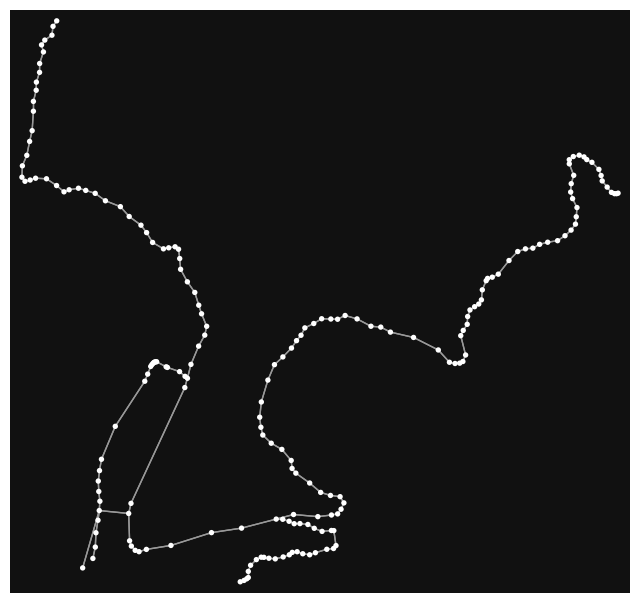

In [5]:
import osmnx as ox

# define the bounding box as a tuple of (left, bottom, right, top) coordinates

# 31.787875, 76.977413
# 31.775067, 76.996163
# The distance is between the two gps coordinates is 
# 2.27 KM or 
# 1.41 Miles or 
# 1.23 Nautical miles or 
# 2273.62 meters


# The distance is between the two gps coordinates is 
# 610.26 KM or 
# 379.20 Miles or 
# 329.51 Nautical miles or 
# 610261.31 meters



# # unpack the bounding box tuple into separate variables
# left, bottom, right, top = bbox

# get the graph from the bounding box
G = ox.graph_from_bbox(31.787875,31.775067,76.996163,76.977413, network_type='all', simplify=False)

# plot the graph
fig, ax = ox.plot_graph(G)


In [13]:
import rasterio
import osmnx as ox

# open the TIF file
with rasterio.open(landcover) as src:

    # get the affine transformation matrix
    arr = src.read(1)
    transform = src.transform

    # get the width and height of the dataset
    width = src.width
    height = src.height
    print(width)
    print(height)
    print((src.bounds))
    # West (left), South (bottom), East (right), North (top)
    # north, south, east, west

    # G = ox.graph_from_bbox(src.bounds.top,src.bounds.bottom,src.bounds.right,src.bounds.left, network_type='all', simplify=False)
    G = ox.graph_from_bbox(src.bounds.top,src.bounds.bottom,src.bounds.right,src.bounds.left, network_type='all', simplify=False)

    # # loop through all the pixels in the dataset
    # for row in range(height):
    #     for col in range(width):

    #         # calculate the location coordinates of the pixel
    #         x, y = transform * (col, row)

    #         # print the location coordinates (lon,lat)
    #         # print(f'Pixel ({col}, {row}) is located at ({x}, {y})')


5749
3676
BoundingBox(left=74.91762312044898, bottom=30.230440353741923, right=80.08203768885211, top=33.53264733816528)


In [15]:
# print(arr)
lat, lng = 31.777960, 76.988043
c = ox.nearest_edges(G, lng,lat)

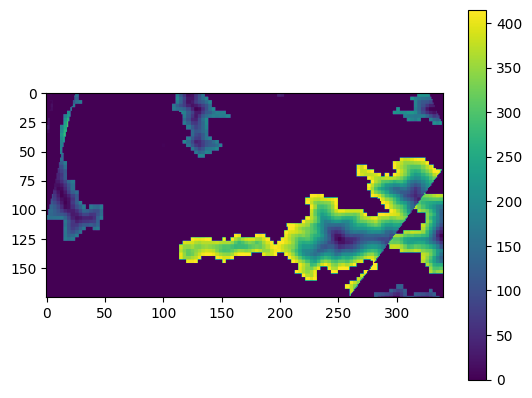

In [33]:

dem_file = "/Users/aakash/Desktop/MTP2/exp/elevation/iit_mandi1.tif"
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Load the dem file
# dem_file = "dem.tif"
with rasterio.open(dem_file) as src:
    elevation_data = src.read(1)

# Extract the contours from the elevation data
contour_levels = np.arange(1500, np.max(elevation_data), 300) # adjust the levels as needed
contours = []
for level in contour_levels:
    contours += measure.find_contours(elevation_data, level)

# Sort the contours by decreasing maximum elevation value
sorted_contours = sorted(contours, key=lambda contour: np.max(elevation_data[np.floor(contour[:, 0]).astype(int), np.floor(contour[:, 1]).astype(int)]), reverse=True)

# Create an array to store the prominence values for each point in the elevation data
prominence_data = np.zeros_like(elevation_data)

# Iterate over each contour in the sorted list of contours
for contour in sorted_contours:
    # Find the maximum elevation value within the contour
    contour_mask = measure.grid_points_in_poly(elevation_data.shape, contour)
    max_elevation_contour = np.max(np.ma.masked_array(elevation_data, ~contour_mask))

    # Update the prominence values for each point in the contour
    for i in range(elevation_data.shape[0]):
        for j in range(elevation_data.shape[1]):
            if contour_mask[i, j] == True:
                # Calculate the prominence of the point
                prominence = max_elevation_contour - elevation_data[i, j]

                # Update the prominence value for the point
                prominence_data[i, j] = prominence

# Plot the prominence data
plt.imshow(prominence_data, cmap='viridis', vmax=np.percentile(prominence_data, 99))
plt.colorbar()
plt.show()


In [8]:
# boudning box - done
# get graph - done
# find coordinates to nearest node for each point
# return a new matrix
import osmnx as ox
from helper import distanceBetwenPoints
import numpy as np
bbox = []

def getRoadData(bounds, transform, height, width,resolution):
   """
   bbox : left, bottom, right, top
   """
   bbox = [bounds.top,bounds.bottom,bounds.right,bounds.left]
   G = ox.graph_from_bbox(*bbox, network_type='all', simplify=False)

   # G = ox.graph_from_bbox(31.787875,31.775067,76.996163,76.977413, network_type='all', simplify=False)

   road = np.zeros((height, width))

   # loop through all the pixels in the dataset
   for row in range(height):
      for col in range(width):
         # calculate the location coordinates of the pixel
         lon, lat = transform * (col, row)
         a,b,c = ox.nearest_edges(G, lon,lat,return_dist = False)
         a_lat, a_lon = G.nodes[a]['y'], G.nodes[a]['x']
         # b_lat, b_lon = G.nodes[b]['y'], G.nodes[b]['x']
         dist = distanceBetwenPoints(lat,a_lat,lon,a_lon)*1000
         if(dist<=resolution):
            road[row,col] = 1
   return road

getRoadData(bbox,0,0,0,0)



    

    


31.7756702 76.9872908
0.04970414340847356


In [1]:
import osmnx as ox

osm_file = "/Users/aakash/Downloads/north.osm"
# Specify the path to your .osm.pbf file
# filepath = 'path/to/your/file.osm.pbf'

# Load the graph from the .osm.pbf file
G = ox.graph_from_xml(osm_file, simplify=False)

# Print the number of nodes and edges in the graph
print(len(G.nodes()), len(G.edges()))
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)


In [2]:
# import osmium
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from shapely.geometry import box



# class RoadHandler(osmium.SimpleHandler):
#     def __init__(self, bbox):
#         super(RoadHandler, self).__init__()
#         self.bbox = bbox
#         self.roads = []

#     def way(self, w):
#         if 'highway' in w.tags:
#             coords = []
#             for node in w.nodes:
#                 coords.append((node.lon, node.lat))
#             line = LineString(coords)
#             if line.intersects(self.bbox):
#                 self.roads.append({'geometry': line, 'highway': w.tags['highway']})

# # Define the bounding box as a shapely Polygon
# # bbox = Point(lon_min, lat_min).buffer(0.1)
# bbox = box(74.91762312044898, 30.230440353741923, 80.08203768885211, 33.53264733816528)

# # Initialize the Osmium handler and apply it to the .osm.pbf file
# osm_handler = RoadHandler(bbox)
# osmium_simple_walker = osmium.SimpleHandler()
# osm_file_path = "/Users/aakash/Downloads/northern-zone-latest.osm.pbf"
# osmium_simple_walker.apply_file(osm_file_path, locations=True, idx='flex_mem')
# osm_handler.apply_file(osm_file_path, locations=True, idx='flex_mem')

# # Convert the roads to a GeoDataFrame
# roads_gdf = gpd.GeoDataFrame(osm_handler.roads, crs='EPSG:4326')


In [3]:
roads_gdf

,geometry,highway
0,"LINESTRING (75.86116 30.86311, 75.86085 30.863...",service
1,"LINESTRING (75.86055 30.86014, 75.86044 30.860...",service
2,"LINESTRING (75.86263 30.85795, 75.86260 30.858...",service
3,"LINESTRING (75.86278 30.85795, 75.86281 30.856...",service
4,"LINESTRING (75.86281 30.85680, 75.86358 30.856...",service
...,...,...
409238,"LINESTRING (74.92948 32.96979, 74.92919 32.970...",unclassified
409239,"LINESTRING (74.93626 32.98322, 74.93645 32.982...",footway
409240,"LINESTRING (74.93166 32.98066, 74.93167 32.979...",unclassified
409241,"LINESTRING (77.17746 32.16834, 77.17727 32.168...",service


In [1]:
import osmium
import geopandas as gpd
from shapely.geometry import Point, LineString

class RoadHandler(osmium.SimpleHandler):
    def __init__(self):
        super(RoadHandler, self).__init__()
        self.roads = []

    def way(self, w):
        if 'highway' in w.tags:
            coords = []
            for node in w.nodes:
                coords.append((node.lon, node.lat))
            line = LineString(coords)
            self.roads.append({'geometry': line, 'highway': w.tags['highway']})

# Initialize the Osmium handler and apply it to the .osm.pbf file
osm_handler = RoadHandler()
osm_file_path = "/Users/aakash/Downloads/northern-zone-latest.osm.pbf"
osmium_simple_walker = osmium.SimpleHandler()
osmium_simple_walker.apply_file(osm_file_path, locations=True, idx='flex_mem')
osm_handler.apply_file(osm_file_path, locations=True, idx='flex_mem')

# Convert the roads to a GeoDataFrame
roads_gdf = gpd.GeoDataFrame(osm_handler.roads, crs='EPSG:4326')


In [2]:
roads_gdf

,geometry,highway
0,"LINESTRING (77.23162 28.67010, 77.23140 28.670...",primary
1,"LINESTRING (74.59119 30.94309, 74.59147 30.943...",trunk_link
2,"LINESTRING (75.86116 30.86311, 75.86085 30.863...",service
3,"LINESTRING (75.86055 30.86014, 75.86044 30.860...",service
4,"LINESTRING (75.86263 30.85795, 75.86260 30.858...",service
...,...,...
1605358,"LINESTRING (73.21263 29.47363, 73.21263 29.473...",unclassified
1605359,"LINESTRING (74.71993 32.47034, 74.71989 32.469...",unclassified
1605360,"LINESTRING (74.75544 32.46292, 74.75346 32.463...",primary
1605361,"LINESTRING (74.71656 32.47150, 74.71645 32.47149)",residential


In [4]:
import osmium
import geopandas as gpd
from shapely.geometry import Point, LineString
from helper import  distanceBetwenPoints

class RoadHandler(osmium.SimpleHandler):
    def __init__(self):
        super(RoadHandler, self).__init__()
        self.lines = []

    def way(self, w):
        if 'highway' in w.tags:
            for i in range(1, len(w.nodes)):
                coords = [(w.nodes[i-1].lon, w.nodes[i-1].lat),
                          (w.nodes[i].lon, w.nodes[i].lat)]
                line = LineString(coords)
                length = distanceBetwenPoints(w.nodes[i-1].lat,w.nodes[i].lat,w.nodes[i-1].lon,w.nodes[i].lon)*1000
                self.lines.append({'geometry': line, 'highway': w.tags['highway'],'length': length,})

# Initialize the Osmium handler and apply it to the .osm.pbf file
osm_handler = RoadHandler()
osm_file_path = "/Users/aakash/Downloads/northern-zone-latest.osm.pbf"
osmium_simple_walker = osmium.SimpleHandler()
osmium_simple_walker.apply_file(osm_file_path, locations=True, idx='flex_mem')
osm_handler.apply_file(osm_file_path, locations=True, idx='flex_mem')

# Convert the lines to a GeoDataFrame
lines_gdf = gpd.GeoDataFrame(osm_handler.lines, crs='EPSG:4326')


In [23]:
lines_gdf.head()

,geometry,highway,length
0,"LINESTRING (77.23162 28.67010, 77.23140 28.67071)",primary,71.185671
1,"LINESTRING (77.23140 28.67071, 77.23107 28.67177)",primary,122.431239
2,"LINESTRING (77.23107 28.67177, 77.23101 28.67194)",primary,20.197112
3,"LINESTRING (77.23101 28.67194, 77.23066 28.67332)",primary,156.747415
4,"LINESTRING (77.23066 28.67332, 77.23020 28.67493)",primary,184.557656


In [7]:
# lines_gdf.to_csv("data.csv")

In [16]:
small_df = lines_gdf[:10]

In [19]:
tuple(small_df['geometry'])

(<LINESTRING (77.232 28.67, 77.231 28.671)>,
 <LINESTRING (77.231 28.671, 77.231 28.672)>,
 <LINESTRING (77.231 28.672, 77.231 28.672)>,
 <LINESTRING (77.231 28.672, 77.231 28.673)>,
 <LINESTRING (77.231 28.673, 77.23 28.675)>,
 <LINESTRING (77.23 28.675, 77.23 28.676)>,
 <LINESTRING (77.23 28.676, 77.23 28.676)>,
 <LINESTRING (77.23 28.676, 77.23 28.678)>,
 <LINESTRING (77.23 28.678, 77.229 28.679)>,
 <LINESTRING (74.591 30.943, 74.591 30.943)>)

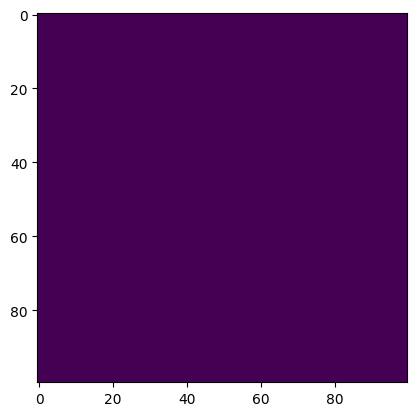

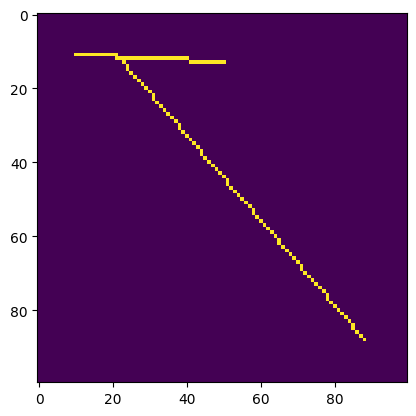

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def bresenham(x0, y0, x1, y1, arr):
    """Draw a line between two points in a numpy array using Bresenham's algorithm."""
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while x0 != x1 or y0 != y1:
        arr[y0, x0] = 1  # mark the point as visited
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    arr[y0, x0] = 1  # mark the final point as visited

# example usage

arr = np.zeros((100, 100))
plt.imshow(arr)
plt.show()
bresenham(21, 11, 88, 88, arr)
bresenham(10, 11, 50, 13, arr)
plt.imshow(arr)
plt.show()
